# Hermit Totems

![Hermit Totems](https://i.redd.it/tz7do0u35zp91.png)

I love love love these totem designs, and their creator has [put them out as a resource pack that](https://www.reddit.com/r/HermitCraft/comments/xnir7p/comment/ipyilcw/?utm_source=share&utm_medium=web2x&context=3) that allows you to turn a totem into _any_ of these via `CustomModelData`.

So what I want to do right now is integrate this resource pack into my 3D printing datapack, which, for 29 designs, would be tedious AF to do by hand. Scripting language to the rescue!

## Imports and Setup

In [1]:
import json

from IPython.display import Markdown, display

## Command Template

The commands I have [right now](https://github.com/OpenBagTwo/chappeau/blob/a34c2efc927565de37087720dc6015f6fc83c9be/Chappeau%20Datapack/data/chappeau/functions/squiddoprint.mcfunction) are of the following form:

> ```mcfunction
> execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:0b, id:"minecraft:carved_pumpkin"}, {Slot:1b, id:"minecraft:paper", tag:{display: {Name: '{"text":"aquarium_core.gcode"}'}}}]} run data modify entity @e[type=minecraft:glow_item_frame, distance=0, limit=1] Item set value {id:"minecraft:carved_pumpkin", tag:{CustomModelData:3, display:{Name:'{"text":"Aquarium Core"}'}}, Count:1b}
>
> execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:0b, id:"minecraft:carved_pumpkin"}, {Slot:1b, id:"minecraft:paper", tag:{display: {Name: '{"text":"aquarium_core.gcode"}'}}}]} run data modify block ~ ~1 ~ Items[{Slot:0b}] merge value {Count:0b} 
> ```

with the first command "printing" the item and the second removing the "filament" from the printer.

There's an "optimization" I'm going to do here that may or may not have a performance benefit, but at the very least is a little DRYer:

```mcfunction
execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:0b, id:"minecraft:totem_of_undying"}, {Slot:1b, id:"minecraft:paper"}]} run function chappeau:hermit_totem
```

and then this `hermit_totem.mcfunction` file can look like:

```mcfunction

# Desc: "3D print" a Hermit Totem
#
# Called by: chappeau:squiddoprint

execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:1b, id:"minecraft:paper", tag:{display: {Name: '{"text":"docm77.gcode"}'}}}]} run data modify entity @e[type=minecraft:glow_item_frame, distance=0, limit=1] Item set value {id:"minecraft:totem_of_undying", tag:{CustomModelData:901, display:{Name:'{"text":"Totem of docm77"}'}}, Count:1b}

execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:1b, id:"minecraft:paper", tag:{display: {Name: '{"text":"grian.gcode"}'}}}]} run data modify entity @e[type=minecraft:glow_item_frame, distance=0, limit=1] Item set value {id:"minecraft:totem_of_undying", tag:{CustomModelData:902, display:{Name:'{"text":"Totem of grian"}'}}, Count:1b}

...

data modify block ~ ~1 ~ Items[{Slot:0b}] merge value {Count:0b}
```

Splitting it out this way:
1. means skipping _all_ hermit-printing commands if there is no totem loaded in the first slot
1. reduces the total number of commands we'd be adding from 29x2 to 1 + (29+1), though at the risk of the printer "eating" the totem if there's a mis-named piece of paper in that first slot.

Okay, actually typing that out, it sounds like a pretty big negative, haha.

So with that in mind, I'll defer the question of whether to split the hermit printing to a separate function but proceed with the template:

In [2]:
COMMAND_TEMPLATE = (
    "execute if block ~ ~1 ~ minecraft:hopper{Items:[<<CONTENT_CHECK>>]}"
    " run data modify entity @e[type=minecraft:glow_item_frame, distance=0, limit=1] Item set value"
    ' {id:"<<BASE_ITEM>>", tag:{CustomModelData:<<MODEL_NUM>>, display:{Name:\'{"text":"<<NAME>>"}\'}}, Count:1b}'
    "\n"
    "execute if block ~ ~1 ~ minecraft:hopper{Items:[<<CONTENT_CHECK>>]}"
    " run data modify block ~ ~1 ~ Items[{Slot:0b}] merge value {Count:0b}"
)

CODE_ONLY_CHECK = (
    '{Slot:1b, id:"minecraft:paper", tag:{display:{Name:\'"<<CODE>>.gcode"\'}}}'
)

ITEM_AND_CODE_CHECK = '{Slot:0b, id:"<<BASE_ITEM>>"},' + CODE_ONLY_CHECK

In [3]:
def generate_print_commands(
    base_item: str, model_num: int, code: str, name: str, sub_function=True
) -> str:
    """Generate "3D printing" commands

    Parameters
    ----------
    base_item : str
        The ID of the "filament" (item to be converted)
    model_num : int
        The value to give as CustomModelData
    code : str
        The filename of the "gcode" (sans ".gcode" extension)
    name : str
        The display name for the item
    sub_function : bool, optional
        By default this method will assume that the generated commands
        are going in a sub-function that will be called by a parent
        function that's already checked if the base item is in the
        first slot. If your goal is to place these commands in
        the main squiddoprint function file, pass in sub_function=False.

    Returns
    -------
    str
        The commands to write to your datapack file
    """
    return (
        COMMAND_TEMPLATE.replace(
            "<<CONTENT_CHECK>>",
            CODE_ONLY_CHECK if sub_function else ITEM_AND_CODE_CHECK,
        )
        .replace("<<BASE_ITEM>>", base_item)
        .replace("<<MODEL_NUM>>", str(model_num))
        .replace("<<CODE>>", code)
        .replace("<<NAME>>", name)
    )

Can you tell I'm not just thinking ahead to future models but thinking about refactoring my existing code?

## Load the custom model data

In [4]:
with open("../_static/totem_of_undying.json") as model_file:
    custom_totems = json.load(model_file)["overrides"]

display(Markdown(f"Model data specifies {len(custom_totems)} overrides"))

Model data specifies 29 overrides

In [5]:
totem_list: list[tuple[int, str]] = []
for entry in custom_totems:
    model_num = int(entry["predicate"]["custom_model_data"])
    variant_name = entry["model"][len("item/totem_of_undying/") : -len("_totem")]
    print(f" - {model_num}: {variant_name}")
    totem_list.append((model_num, variant_name))

 - 900: brazen
 - 901: docm77
 - 902: grian
 - 903: mumbo
 - 904: etho
 - 905: bdubs
 - 906: xisuma
 - 907: scar
 - 908: beef
 - 909: cleo
 - 910: cubfan
 - 911: hypno
 - 912: ijevin
 - 913: impulse
 - 914: iskall
 - 915: joehills
 - 916: keralis
 - 917: tango
 - 918: tfc
 - 919: welsknight
 - 920: xb
 - 921: zedaph
 - 922: false
 - 923: pearl
 - 924: stress
 - 925: gem
 - 926: renking
 - 927: grumbot
 - 928: impulsedwarf


So that parsed okay, but mapping to display names is something I'm gonna want to do by hand.

In [6]:
NAME_LOOKUP: dict[str, str] = {
    # I'm going by the stylizations of their names from hermitcraft.com
    # and omitting any cases where the default handling (title case) is correct
    "brazen": "BrazenWolf",
    "docm77": "the GOAT",
    "xisuma": "XisumaVoid",
    "bdubs": "BdoubleO",
    "cubfan": "Cub",
    "gem": "GeminiTay",
    "impulse": "Impulse",
    "iskall": "Iskall",
    "ijevin": "iJevin",
    "joehills": "Joe",
    "mumbo": "MumboJumbo",
    "pearl": "the PearlescentMoon",
    "renking": "King Ren",
    "tango": "Tango Tek",
    "tfc": "TFC",
    "welsknight": "Wels",
    "beef": "Beef",
    "xb": "xBCrafted",  # tempted to use "princess"
    "zedaph": "Zedaph",
    "cleo": "Cleo",
    "impulsedwarf": "Imli",  # creative license
}


def get_display_name(code: str) -> str:
    """Get the display name for a given custom totem

    Parameters
    ----------
    code : str
        The shortened name used to specify the model
        file that'll also be used for the "gcode"

    Returns
    -------
    str
        A suitable display name
    """
    return f"Totem of {NAME_LOOKUP.get(code, code.title())}"

Run it through the list:

In [7]:
for model_num, code in totem_list:
    print(f" - {model_num} : {get_display_name(code)}")

 - 900 : Totem of BrazenWolf
 - 901 : Totem of the GOAT
 - 902 : Totem of Grian
 - 903 : Totem of MumboJumbo
 - 904 : Totem of Etho
 - 905 : Totem of BdoubleO
 - 906 : Totem of XisumaVoid
 - 907 : Totem of Scar
 - 908 : Totem of Beef
 - 909 : Totem of Cleo
 - 910 : Totem of Cub
 - 911 : Totem of Hypno
 - 912 : Totem of iJevin
 - 913 : Totem of Impulse
 - 914 : Totem of Iskall
 - 915 : Totem of Joe
 - 916 : Totem of Keralis
 - 917 : Totem of Tango Tek
 - 918 : Totem of TFC
 - 919 : Totem of Wels
 - 920 : Totem of xBCrafted
 - 921 : Totem of Zedaph
 - 922 : Totem of False
 - 923 : Totem of the PearlescentMoon
 - 924 : Totem of Stress
 - 925 : Totem of GeminiTay
 - 926 : Totem of King Ren
 - 927 : Totem of Grumbot
 - 928 : Totem of Imli


## Put it All Together

And yeah, I'm gonna make this a separate function for the purpose of this notebook

In [8]:
for model_num, code in totem_list:
    print(
        generate_print_commands(
            "minecraft:totem_of_undying", model_num, code, get_display_name(code)
        )
        + "\n"
    )

execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:1b, id:"minecraft:paper", tag:{display:{Name:'"brazen.gcode"'}}}]} run data modify entity @e[type=minecraft:glow_item_frame, distance=0, limit=1] Item set value {id:"minecraft:totem_of_undying", tag:{CustomModelData:900, display:{Name:'{"text":"Totem of BrazenWolf"}'}}, Count:1b}
execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:1b, id:"minecraft:paper", tag:{display:{Name:'"brazen.gcode"'}}}]} run data modify block ~ ~1 ~ Items[{Slot:0b}] merge value {Count:0b}

execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:1b, id:"minecraft:paper", tag:{display:{Name:'"docm77.gcode"'}}}]} run data modify entity @e[type=minecraft:glow_item_frame, distance=0, limit=1] Item set value {id:"minecraft:totem_of_undying", tag:{CustomModelData:901, display:{Name:'{"text":"Totem of the GOAT"}'}}, Count:1b}
execute if block ~ ~1 ~ minecraft:hopper{Items:[{Slot:1b, id:"minecraft:paper", tag:{display:{Name:'"docm77.gcode"'}}}]} run data modify bloc

Paste & test!

## Success!

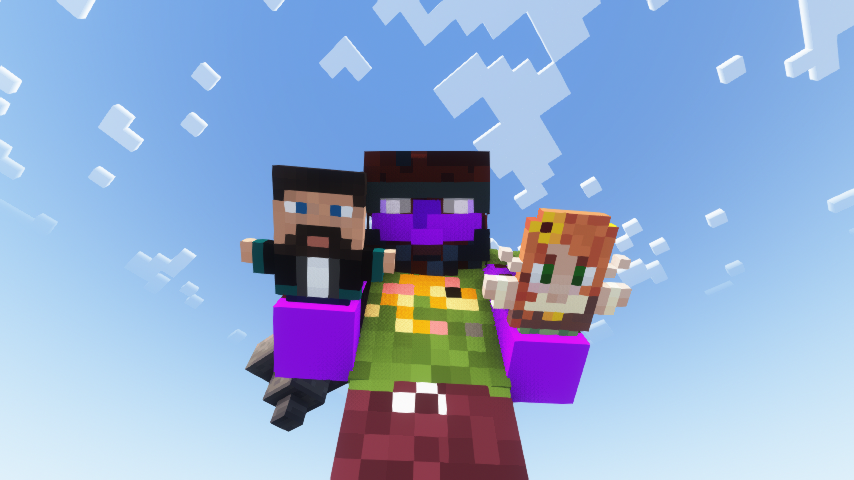

Totally got it right on the first try too. Absolutely didn't mess up the syntax at any point and have to rerun.